In [61]:
import numpy as np
import pandas as pd
from datetime import date
from random import seed
from random import random

import time
import scipy, scipy.signal
import os, os.path
import shutil
import matplotlib
import matplotlib.pyplot as plt

from pylab import imshow

# vgg16 model used for transfer learning on the dogs and cats dataset
from matplotlib import pyplot
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
import tensorflow as tf
# from keras.optimizers import SGD

from keras.layers import Conv2D
from keras.layers import MaxPooling2D

# from keras.optimizers import gradient_descent_v2
# SGD = gradient_descent_v2.SGD(...)

from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator


import h5py
import sys
sys.path.append('/Users/hn/Documents/00_GitHub/Ag/NASA/Python_codes/')
import NASA_core as nc
import NASA_plot_core as rcp

In [62]:
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array

In [63]:
# from keras.preprocessing.image import load_img # commented out in windows
# from keras.preprocessing.image import img_to_array # commented out in windows
from keras.models import load_model

# Read Fields Metadata

In [64]:
meta_dir = "/Users/hn/Documents/01_research_data/NASA/parameters/"
meta = pd.read_csv(meta_dir+"evaluation_set.csv")
meta_moreThan10Acr=meta[meta.ExctAcr>10]
print (meta.shape)
print (meta_moreThan10Acr.shape)
meta.head(2)

(6340, 8)
(3539, 8)


,ID,CropTyp,Irrigtn,DataSrc,Acres,ExctAcr,LstSrvD,county
0,100010_WSDA_SF_2017,alfalfa hay,center pivot,wsda,34,34.310305,2017/09/12,Grant
1,100204_WSDA_SF_2017,alfalfa hay,center pivot,wsda,62,61.826535,2017/08/09,Grant


In [65]:
meta_moreThan10Acr.head(2)

,ID,CropTyp,Irrigtn,DataSrc,Acres,ExctAcr,LstSrvD,county
0,100010_WSDA_SF_2017,alfalfa hay,center pivot,wsda,34,34.310305,2017/09/12,Grant
1,100204_WSDA_SF_2017,alfalfa hay,center pivot,wsda,62,61.826535,2017/08/09,Grant


In [66]:
meta_moreThan10Acr_IDs = list(meta_moreThan10Acr.ID.unique())

In [67]:
len(meta_moreThan10Acr_IDs)

3539

In [68]:
idx = "EVI"
train_folder = '/Users/hn/Documents/01_research_data/NASA/ML_data/train_images_' + idx + '/'
test_folder = "/Users/hn/Documents/01_research_data/NASA/ML_data/limitCrops_nonExpert_images/"


# Prepare final dataset

#### First do 80-20 split like SVM. So, everything is consistent.

In [69]:
ML_data_folder = "/Users/hn/Documents/01_research_data/NASA/ML_data/"
train80 = pd.read_csv(ML_data_folder+"train80_split_expertLabels_2Bconsistent.csv")
test20 = pd.read_csv(ML_data_folder+"test20_split_expertLabels_2Bconsistent.csv")

In [70]:
print (test20.shape)
train80.shape

(269, 2)


(1073, 2)

In [71]:
"100156_WSDA_SF_2017" in list(train80.ID)

True

In [72]:
# organize dataset into a useful structure
# create directories
dataset_home = train_folder + "/train80/"

# create label subdirectories
labeldirs = ['separate_singleDouble/single/', 'separate_singleDouble/double/']
for labldir in labeldirs:
    newdir = dataset_home + labldir
    os.makedirs(newdir, exist_ok=True)
    
# copy training dataset images into subdirectories
for file in os.listdir(train_folder):
    if "_".join(file.split("_")[1:])[:-4] in list(train80.ID):
        src = train_folder + '/' + file
        if file.startswith('single'):
            dst = dataset_home + 'separate_singleDouble/single/' + file
            shutil.copyfile(src, dst)
        elif file.startswith('double'):
            dst = dataset_home + 'separate_singleDouble/double/' + file
            shutil.copyfile(src, dst)

In [73]:
train80.shape

(1073, 2)

In [74]:
len(os.listdir(train_folder+"/train80/separate_singleDouble/single/"))+\
len(os.listdir(train_folder+"/train80/separate_singleDouble/double/"))

1073

# Copy test fields into a separate folder for later use

In [81]:
# organize dataset into a useful structure
# create directories
test_home = train_folder + "/test20/"
os.makedirs(test_home, exist_ok=True)

# copy training dataset images into subdirectories
for file in os.listdir(train_folder):
    if file.endswith('jpg'):
        if not ("_".join(file.split("_")[1:])[:-4] in list(train80.ID)):
            src = train_folder + '/' + file
            dst = test_home + file
            shutil.copyfile(src, dst)

In [82]:
len(os.listdir(test_home))

269

# Plot For Fun

In [47]:
os.listdir(train_folder)[2:4]

['double_1006_WSDA_SF_2016.jpg', 'double_100707_WSDA_SF_2017.jpg']

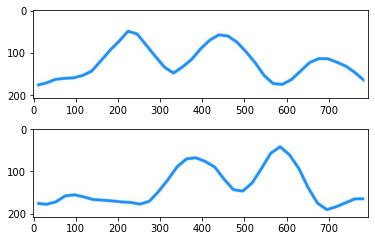

In [50]:
# plot dog photos from the dogs vs cats dataset
from matplotlib.image import imread


# define location of dataset
# plot first few images
files = os.listdir(train_folder)[2:4]
# files = [sorted(os.listdir(train_folder))[2]] + [sorted(os.listdir(train_folder))[-2]]
for i in range(2):
    # define subplot
    pyplot.subplot(210 + 1 + i)
    # define filename
    filename = train_folder + files[i]
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    pyplot.imshow(image)
# show the figure
pyplot.show()

# Full Code

In [51]:
train_folder_80 = train_folder +"/train80/"

In [53]:
# define cnn model
def define_model():
    # load model
    model = VGG16(include_top=False, input_shape=(224, 224, 3))
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(1, activation='sigmoid')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# run the test harness for evaluating a model
def run_test_harness():
    # define model
    _model = define_model()
    # create data generator
    datagen = ImageDataGenerator(featurewise_center=True)
    # specify imagenet mean values for centering
    datagen.mean = [123.68, 116.779, 103.939]
    # prepare iterator
    train_separate_dir = train_folder_80 + "/separate_singleDouble/"
    train_it = datagen.flow_from_directory(train_separate_dir,
                                           class_mode='binary', 
                                           batch_size=16, 
                                           target_size=(224, 224))
    # fit model
    _model.fit(train_it, 
               steps_per_epoch=len(train_it), 
               epochs=10, verbose=1)
    model_dir = "/Users/hn/Documents/01_research_data/NASA/ML_Models/"
    _model.save(model_dir+'01_TL_SingleDoubleEVI_SG_train80.h5')
#     tf.keras.models.save_model(model=trained_model, filepath=model_dir+'01_TL_SingleDouble.h5')
  
#     return(_model)

# entry point, run the test harness
start_time = time.time()
run_test_harness()
end_time = time.time()

Found 1073 images belonging to 2 classes.
Epoch 1/10
68/68 [==============================] - 204s 3s/step - loss: 1.9668 - accuracy: 0.8956
Epoch 2/10
68/68 [==============================] - 222s 3s/step - loss: 0.1339 - accuracy: 0.9609
Epoch 3/10
68/68 [==============================] - 213s 3s/step - loss: 0.0681 - accuracy: 0.9711
Epoch 4/10
68/68 [==============================] - 223s 3s/step - loss: 0.0931 - accuracy: 0.9692
Epoch 5/10
68/68 [==============================] - 218s 3s/step - loss: 0.0422 - accuracy: 0.9814
Epoch 6/10
68/68 [==============================] - 214s 3s/step - loss: 0.0478 - accuracy: 0.9842
Epoch 7/10
68/68 [==============================] - 213s 3s/step - loss: 0.0333 - accuracy: 0.9832
Epoch 8/10
68/68 [==============================] - 215s 3s/step - loss: 0.0372 - accuracy: 0.9730
Epoch 9/10
68/68 [==============================] - 217s 3s/step - loss: 0.0642 - accuracy: 0.9739
Epoch 10/10
68/68 [==============================] - 219s 3s/step -

In [55]:
# photo = load_img(train_folder + files[0], target_size=(200, 500))
# photo